In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import yfinance as yf
from datetime import date
import itertools
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

# Data Preprocessing

In [2]:
# fetch the data
apple = yf.Ticker("AAPL")
apple

yfinance.Ticker object <AAPL>

In [4]:
#Get historical data
apple_data = apple.history(start ="2015-01-01", end=date.today(), interval="1d")

apple_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-07,126.169998,126.320000,124.830002,125.900002,71057600,0.0,0.0
2021-06-08,126.599998,128.460007,126.209999,126.739998,74403800,0.0,0.0
2021-06-09,127.209999,127.750000,126.519997,127.129997,56877900,0.0,0.0
2021-06-10,127.019997,128.190002,125.940002,126.110001,71186400,0.0,0.0
2021-06-11,126.529999,127.440002,126.099998,127.349998,53415300,0.0,0.0


### Data Visualization

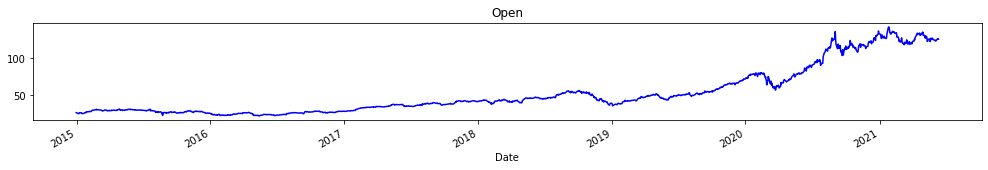

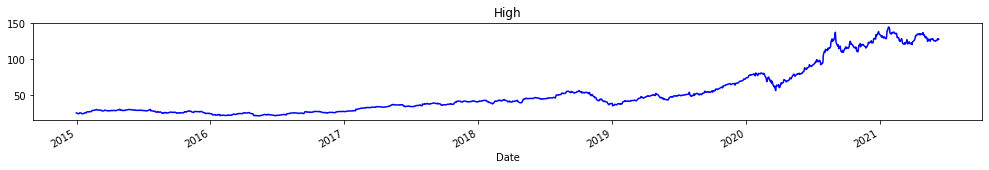

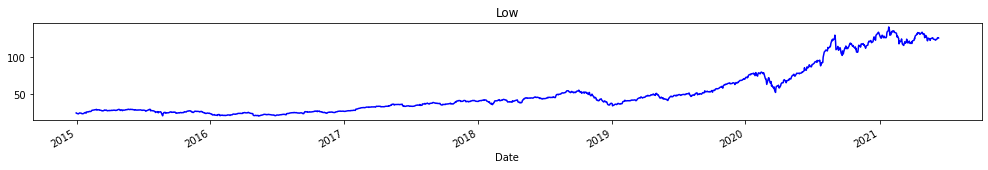

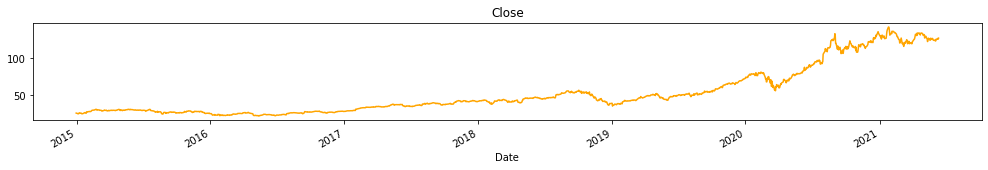

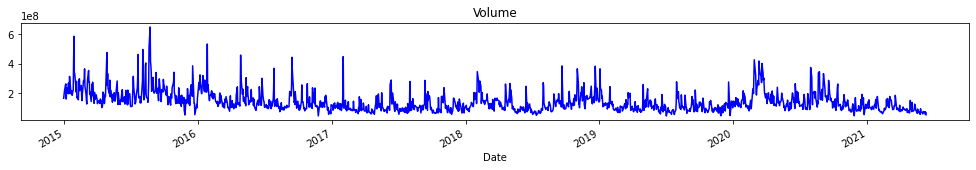

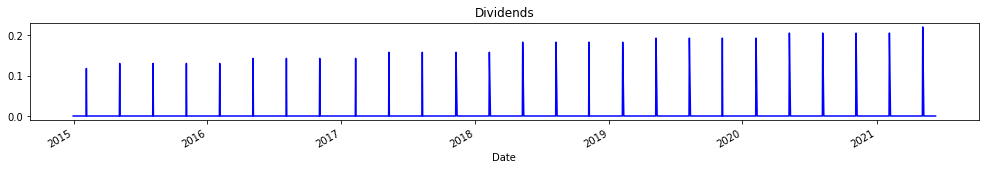

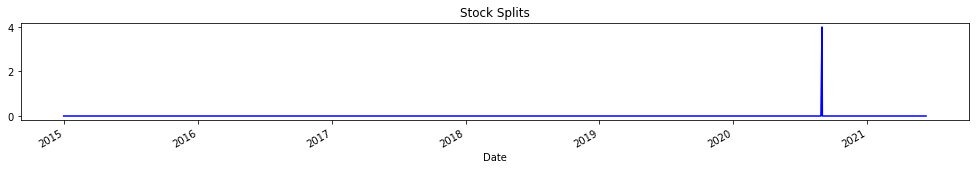

In [6]:
%matplotlib inline

for col in apple_data.columns:
    color="orange" if col == "Close" else "blue"
    apple_data[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [7]:
# Reset the index, change Date to column
apple_data = apple_data.reset_index()
apple_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-12-31,25.611516,25.681889,25.019014,25.057606,165613600,0.0,0.0
1,2015-01-02,25.286885,25.298236,24.369756,24.819241,212818400,0.0,0.0
2,2015-01-05,24.583150,24.664874,23.929355,24.120045,257142000,0.0,0.0
3,2015-01-06,24.185883,24.387924,23.752289,24.122320,263188400,0.0,0.0
4,2015-01-07,24.335706,24.562718,24.222200,24.460564,160423600,0.0,0.0


In [8]:
#check if date is in datetime format
apple_data.Date.dtype

dtype('<M8[ns]')

### Changing the Column names
Facebook prophet takes only two features(columns). The column names must be ds: date, s:close. We are going to rename our columns.

In [9]:
#Extracting the date and close price columns
apple_df = apple_data[["Date", "Close"]]
apple_df.head()

,Date,Close
0,2014-12-31,25.057606
1,2015-01-02,24.819241
2,2015-01-05,24.120045
3,2015-01-06,24.122320
4,2015-01-07,24.460564


In [10]:
#rename the columns
apple_df = apple_df.rename(columns={'Date': 'ds', 'Close': 'y'})
apple_df.head()

,ds,y
0,2014-12-31,25.057606
1,2015-01-02,24.819241
2,2015-01-05,24.120045
3,2015-01-06,24.122320
4,2015-01-07,24.460564


### Splitting the Data

In [12]:
index = int(0.8 * apple_df.shape[0])
train_df = apple_df[:index]
test_df = apple_df[index:]

In [13]:
print(train_df.shape)
print(test_df.shape)

(1298, 2)
(325, 2)


### Hyperparameter Tuning

In [14]:
cutoffs = pd.to_datetime(["2016-01-09", "2016-07-09", "2017-01-09"])

In [15]:
# import itertools
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.diagnostics import cross_validation
# from fbprophet.plot import plot_cross_validation_metric
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_df)  # Fit model with given params
#     df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
#     cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
#     cutoff = df_cv['cutoff'].unique()[0]
#     df_cv = df_cv[df_cv['cutoff'].values == cutoff]

#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

## Fitting the Model

In [16]:
model = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True,yearly_seasonality=True, interval_width = 0.95)
model.add_seasonality('self_define_cycle',period=8,fourier_order=8,mode='additive')
model.fit(train_df)

## Make Future Prediction
👇Before predicting future values with Facebook's Prophet library, you first need to create a placeholder dataframe that will eventually hold the predictions. Once you create the dataframe, try to predict 2 years in the future.

You can create the predictions' dataframe using `make_future_dataframe()`

In [17]:
horizon = 36
future = model.make_future_dataframe(periods =horizon, freq="M")
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1329,2022-09-30,170.696314,-256.595306,561.726971
1330,2022-10-31,176.507790,-276.014575,586.408797
1331,2022-11-30,181.056584,-290.000796,612.502410
1332,2022-12-31,185.940632,-308.676613,632.615726
1333,2023-01-31,190.775682,-332.511041,660.089716


## Plotting the Forecast

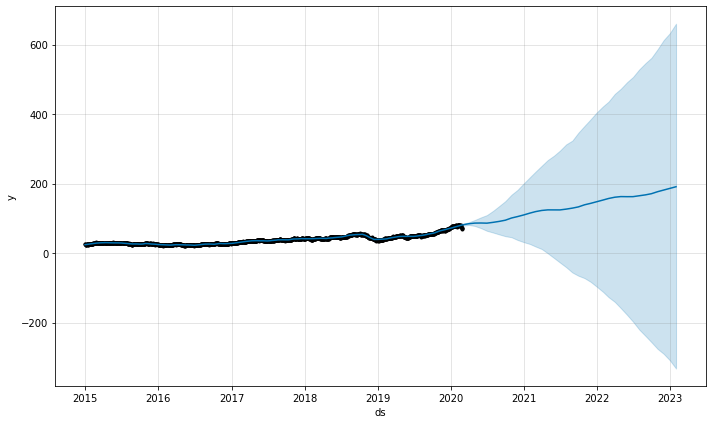

In [18]:
ax = model.plot(forecast);

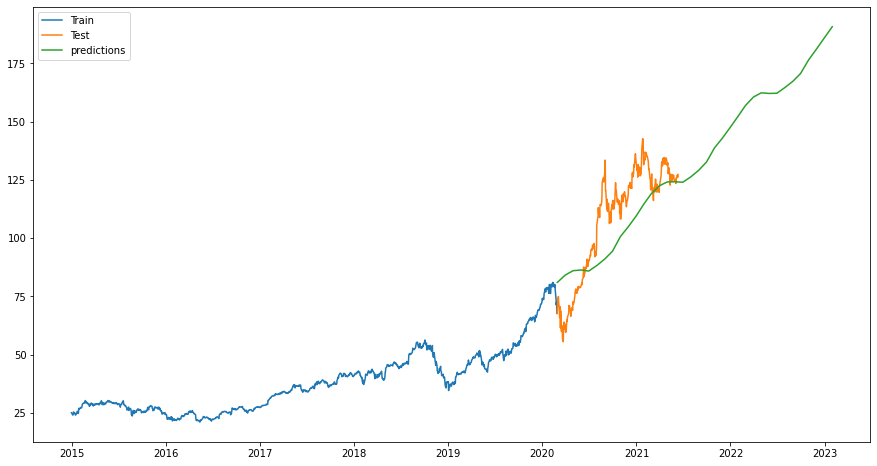

In [19]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

The Train data is from 2015-the beginning of 2020, while the test data is from the beginning of 2020 to middle of 2021 and our forecasted data started predicting from 2020 to 2023

## Time Series' trend and seasonality

👇 Plot the trend and yearly seasonality of the time series. This can be done using the `plot_components()` function from Facebook's Prophet Library

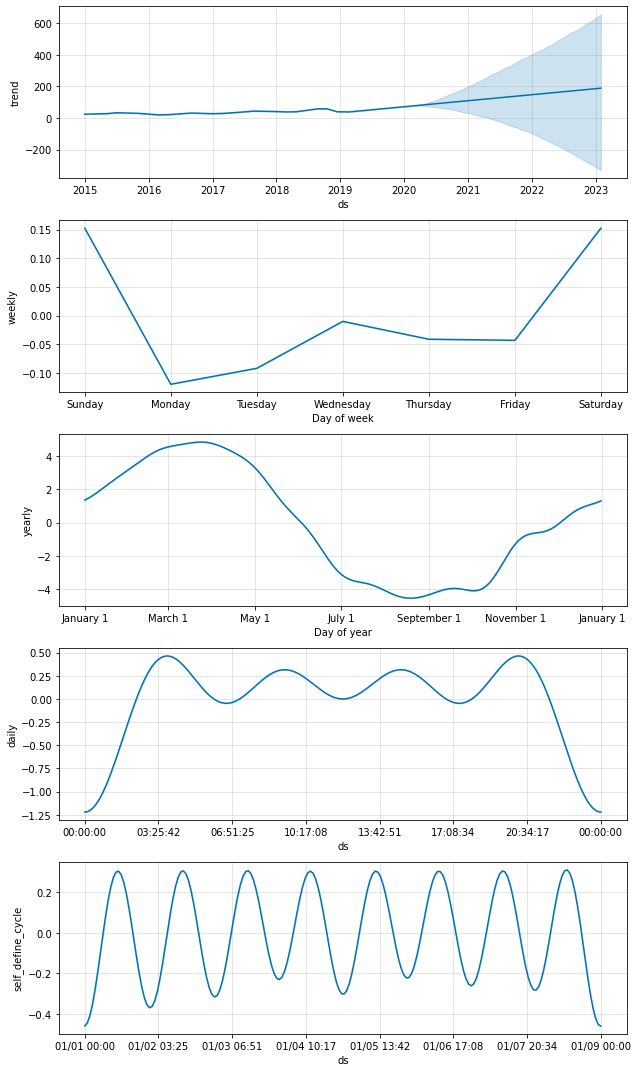

In [20]:
model.plot_components(forecast);

## Evaluating the model with cross-validation!
👇 Using cross_validation() and performance_metrics() from fbprophet.diagnostics, evaluate the performance of your model

More precisely, create a Time Series K-fold CV with

* train sets of size 5 years
* horizon val sizes of 1 years
* shifting each fold by 180 days


In [21]:
# Your code here
cv_results = cross_validation(model=model, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-04 00:00:00 and 2019-02-27 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
cv_results.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
748,2020-02-21,45.193341,-102.360413,178.075514,77.528809,2019-02-27
749,2020-02-24,45.635885,-103.558046,178.908933,73.846161,2019-02-27
750,2020-02-25,45.798713,-103.719670,179.942684,71.344841,2019-02-27
751,2020-02-26,45.964069,-103.915179,180.830894,72.476631,2019-02-27
752,2020-02-27,45.910828,-105.012611,180.724068,67.738968,2019-02-27


In [23]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,2.548872,1.596519,1.290592,0.027916,0.021462,0.853333
1,37 days,2.713593,1.647299,1.331945,0.028760,0.024816,0.853333
2,38 days,2.723438,1.650284,1.339501,0.028881,0.024816,0.853333
3,39 days,2.678273,1.636543,1.323276,0.028575,0.024816,0.860000
4,40 days,2.909232,1.705647,1.361640,0.029337,0.021462,0.875556


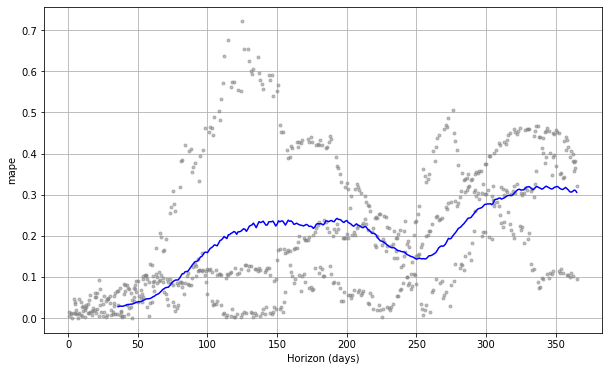

In [24]:
plot_cross_validation_metric(cv_results, metric='mape');

## Tuning our model

In [25]:
m = Prophet(
    growth="linear",
    seasonality_mode="additive",
    changepoint_prior_scale =30,
    seasonality_prior_scale=35,
    holidays_prior_scale = 20,
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,).add_seasonality(
    name="monthly",
    period =30.5,
    fourier_order = 55).add_seasonality(
    name="daily",
    period =1,
    fourier_order = 15).add_seasonality(
    name="weekly",
    period = 7,
    fourier_order = 20).add_seasonality(
    name="yearly",
    period =365.25,
    fourier_order = 20).add_seasonality(
    name="quarterly",
    period =365.25/4,
    fourier_order = 15,
    prior_scale = 15)

In [26]:
m.fit(train_df)

In [27]:
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as apple:
    json.dump(model_to_json(m), apple)

In [28]:
horizon = 36
future = m.make_future_dataframe(periods =horizon, freq="M")
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1329,2022-09-30,173.235397,-153.420821,501.570475
1330,2022-10-31,179.798487,-162.358938,517.995457
1331,2022-11-30,184.586613,-175.026196,541.368464
1332,2022-12-31,189.715236,-185.234505,566.675044
1333,2023-01-31,194.930099,-197.909641,593.010953


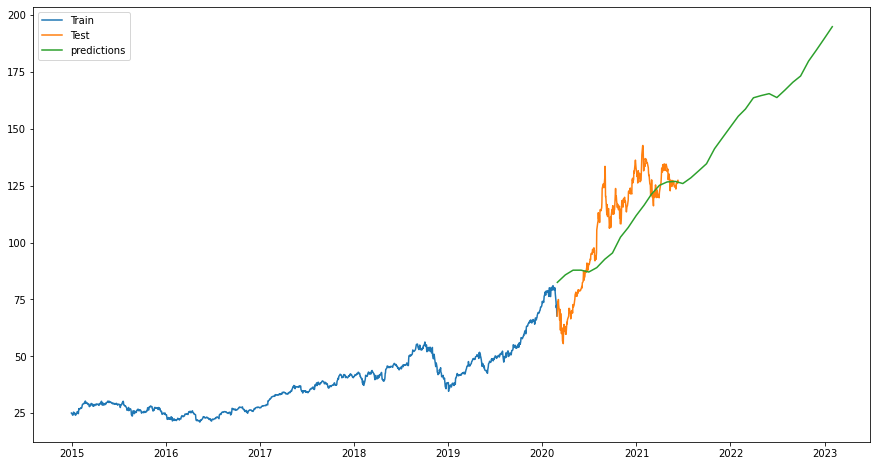

In [29]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast2[-horizon:]['ds'], forecast2[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

In [33]:
# Your code here
cv_results = cross_validation(model=m, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-04 00:00:00 and 2019-02-27 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,1.884249,1.372679,1.140230,0.024719,0.021850,0.560000
1,37 days,1.859233,1.363537,1.126545,0.024367,0.020709,0.586667
2,38 days,1.890479,1.374947,1.130572,0.024326,0.020709,0.586667
3,39 days,1.896047,1.376970,1.136960,0.024443,0.021383,0.593333
4,40 days,2.064996,1.437010,1.162613,0.024893,0.021383,0.604444


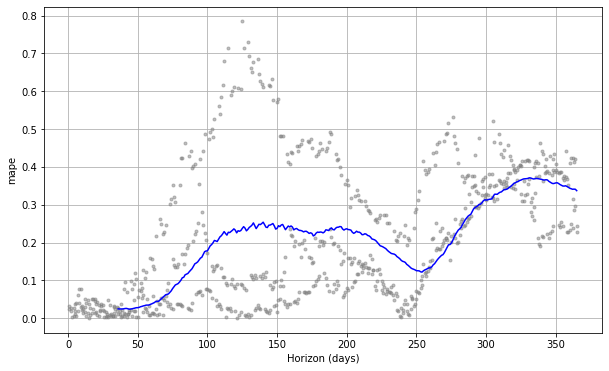

In [35]:
plot_cross_validation_metric(cv_results, metric='mape');